## Finite Difference Method

In the FDM note, we solve Laplace equation in one dimension. Here, let's talk about solve elliptic equation in high dimension. (Laplace equation is one of the elliptic equations)

#### Example:

Let's consider a Poisson equation $\nabla^2u=-\frac{\rho}{\epsilon}$ in two dimensional space. Using finite difference method, we can rewrite the equation as difference equation:

$$u_{i, j}=\frac{1}{4}\left[u_{i, j+1}+u_{i, j-1}+u_{i+1, j}+u_{i-1, j}\right]+\frac{h^{2}}{4\epsilon} \rho_{i, j}$$

There are three kinds of boundary condition: Dirichlet, Neumann and Robin. Since the Robin is linear combination of Dirichlet and Neumann boundary condition, we only discuss the first two.

1. Dirichlet: $u_{i,0}=p$
2. Neumann: $u_{i,0}=p*h+u_{i,1}$

And we use a vector $(u_{1,1},u_{1,2},u_{1,n-1},u_{2,1},...,u_{n-1,n-1})$ to calculate.

Denote the equation as $Au=B$

#### Code Example (Julia language):

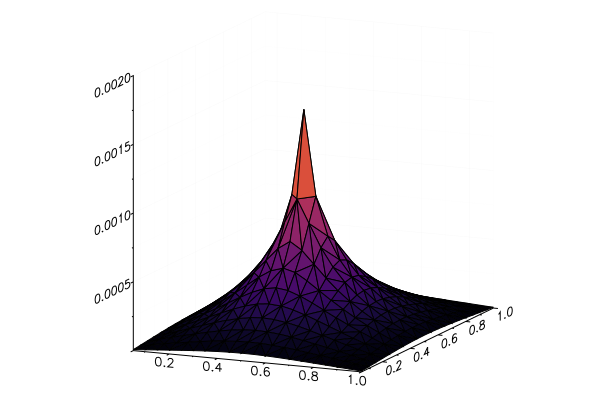

In [7]:
using Plots
include("Elimination.jl")

n = 22  # sizse of mesh, 22*22
h = 0.05
ϵ = 1.0
A = Array{Float64}(undef, (n-2)*(n-2), (n-2)*(n-2))
u = Array{Float64}(undef, (n-2)*(n-2))
B = Array{Float64}(undef, (n-2)*(n-2))
A .= 0
u .= 0
B .= 0

# initialize with boundary value being zero
# ρ is Dirac δ with amplitude 1.0
for i in 1:(n-2)
    for j in 1:(n-2)
        index = (i-1)*(n-2)+j
        if index == 190
            B[index] = 1.0*h^2
        end
        A[index, index] = 4.0
        
        if i == 1
            A[index, index+n-2] = -1.0
        elseif i == (n-2)
            A[index, index-n+2] = -1.0
        else
            A[index, index-n+2] = -1.0
            A[index, index+n-2] = -1.0
        end
        
        if j == 1
            A[index, index+1] = -1.0
        elseif j == n-2
            A[index, index-1] = -1.0
        else
            A[index, index-1] = -1.0
            A[index, index+1] = -1.0
        end
    end
end

# Gaussian elimination
GaussianElimination!(A, B)
u = [B[i]/A[i,i] for i in 1:((n-2)*(n-2))]

x = [j*h for i in 1:(n-2) for j in 1:(n-2)]
y = [i*h for i in 1:(n-2) for j in 1:(n-2)]

plot(x, y, u, t=:surface, leg=false)

### Iterative Method

From the calculation above, we could find it's impossible to calculate a large mesh and the result is not good enough. So we could do iteration to get the result accurate enough.

1. Jacobi's method:$y_{j}^{(i+1)}=\frac{1}{A_{j j}}\left\{b_{j}-\sum_{i=1}^{j-1} A_{j k} y_{k}^{(i)}-\sum_{i=j+1}^{N} A_{j k} y_{k}^{(i)}\right\}$
2. Gauss-Seidel method:$y_{j}^{(i+1)}=\frac{1}{A_{j j}}\left\{b_{j}-\sum_{i=1}^{j-1} A_{j k} y_{k}^{(i+1)}-\sum_{i=j+1}^{N} A_{j k} y_{k}^{(i)}\right\}$
3. SOR method:$y_{j}^{(i+1)}=y_{j}^{(i)}+\frac{\omega}{A_{j j}}\left\{b_{j}-\sum_{i=1}^{j-1} A_{j k} y_{k}^{(i+1)}-\sum_{i=j}^{N} A_{j k} y_{k}^{(i)}\right\}$

where

$$1<\omega<2$$

#### Code Example (Julia language):

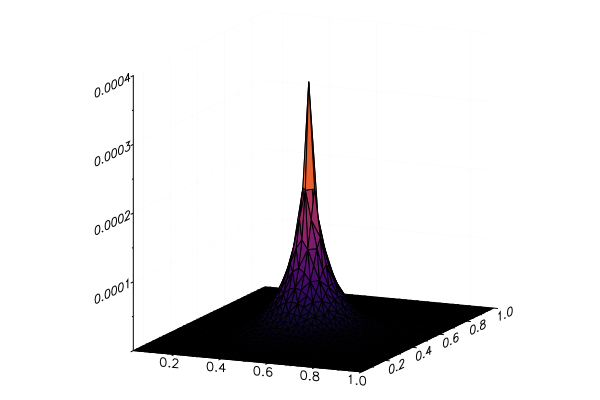

In [14]:
using Plots

# Jacobi's method:
n = 42  # sizse of mesh, 42*42
h = 0.025
δ = 1e-8  # tolerance
ϵ = 1.0
meshOld = Array{Float64}(undef, n-2, n-2)
meshOld .= 0.0
meshNew = Array{Float64}(undef, n-2, n-2)
meshNew .= 0.0

exitLoop = false
for l in 1:100
    if exitLoop
        break
    end
    exitLoop = true
    
    for i in 1:(n-2)
        for j in 1:(n-2)
            if i == 1
                meshNew[i, j] += meshOld[i+1,j]/4
            elseif i == (n-2)
                meshNew[i, j] += meshOld[i-1, j]/4
            else
                meshNew[i, j] += meshOld[i-1, j]/4
                meshNew[i, j] += meshOld[i+1, j]/4
            end
            
            if j == 1
                meshNew[i, j] += meshOld[i,j+1]/4
            elseif j == (n-2)
                meshNew[i, j] += meshOld[i, j-1]/4
            else
                meshNew[i, j] += meshOld[i, j-1]/4
                meshNew[i, j] += meshOld[i, j+1]/4
            end
            
            if (i==20) && (j==20)
                meshNew[i, j] += h^2/4/ϵ
            end
            
            if abs(meshNew[i, j]-meshOld[i, j]) > δ
                exitLoop = false
            end
        end
    end
    
    meshOld .= meshNew
    meshNew .= 0
    
end

# plot mesh
x = [j*h for i in 1:(n-2) for j in 1:(n-2)]
y = [i*h for i in 1:(n-2) for j in 1:(n-2)]
u = [meshOld[i, j] for i in 1:(n-2) for j in 1:(n-2)]
plot(x, y, u, t=:surface, leg=false)